In [118]:
import pandas as pd

In [119]:
bitcoin = pd.read_csv('datasets/coin_Bitcoin.csv')
bitcoin.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [120]:
bitcoin.tail()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11
2990,2991,Bitcoin,BTC,2021-07-06 23:59:59,35038.536363,33599.916169,33723.509655,34235.193451,2.650126e+10,6.418992e+11


In [121]:
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
bitcoin.set_index('Date', inplace=True)
bitcoin.index.freq = 'D'
bitcoin.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


<Axes: xlabel='Date'>

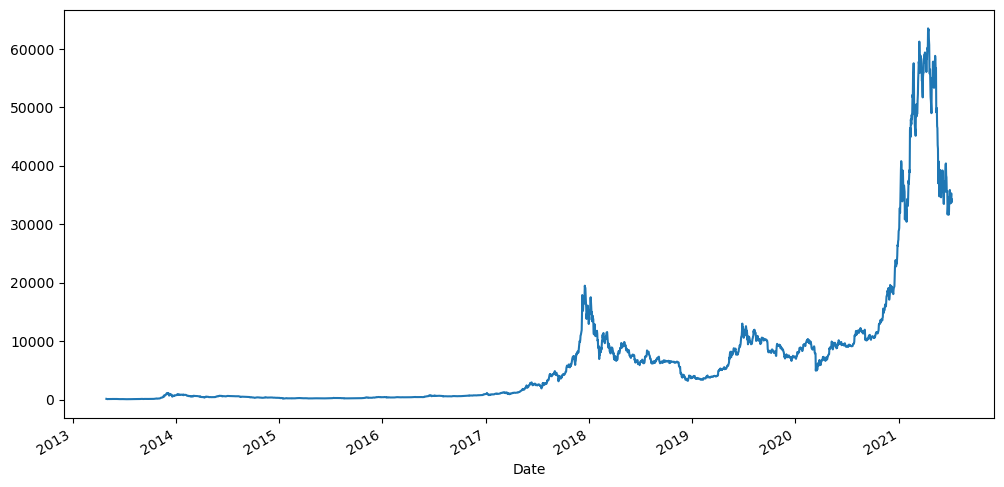

In [122]:
bitcoin['Close'].plot(figsize=(12, 6))

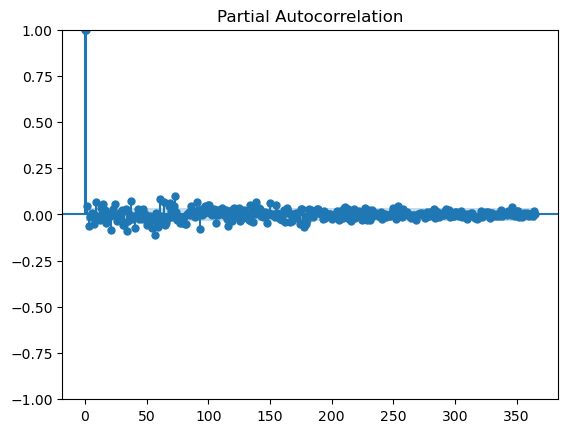

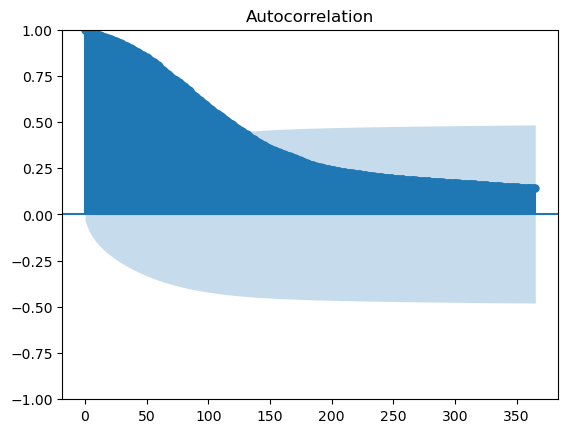

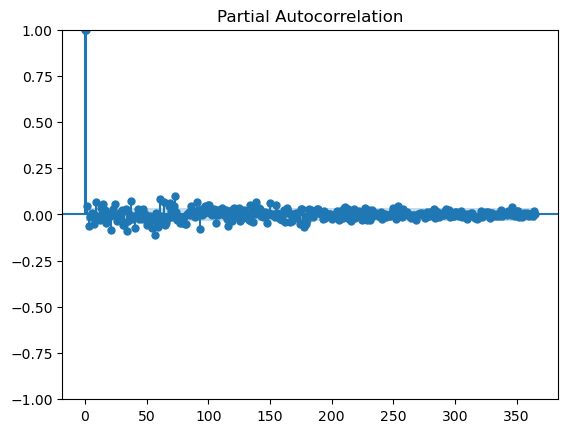

In [123]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin['Close'], lags=365)
plot_pacf(bitcoin['Close'], lags=365)

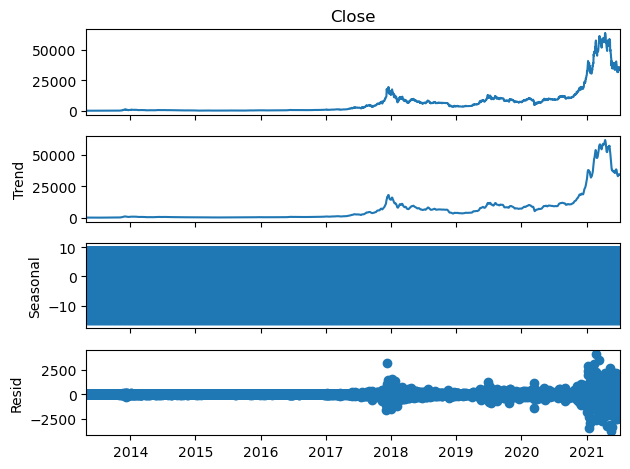

In [124]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(bitcoin['Close'], model='add')
result.plot();

In [146]:
from statsmodels.tsa.stattools import adfuller

adfuller(bitcoin['Close'])[1]
bitcoin['Difference_Close'] = bitcoin['Close'].diff()
adfuller(bitcoin['Difference_Close'].dropna())[1]

1.0955855128655049e-14

In [147]:
from pmdarima import auto_arima

model = auto_arima(bitcoin['Difference_Close'].dropna(), seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2990
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -23292.787
Date:                Fri, 24 May 2024   AIC                          46593.574
Time:                        22:35:12   BIC                          46617.586
Sample:                    04-30-2013   HQIC                         46602.213
                         - 07-06-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4788      0.052      9.194      0.000       0.377       0.581
ar.L2          0.1068      0.006     19.124      0.000       0.096       0.118
ma.L1         -0.5484      0.052    -10.506      0.000      -0.651      -0.446
sigma2      3.427e+05   2024.082    169.320      0.000    3.39e+05    3.47e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            195227.76
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):            1426.89   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
forecast_length = 30

In [154]:
train_arima = bitcoin['Difference_Close'].iloc[:-forecast_length]
test_arima = bitcoin['Difference_Close'].iloc[-forecast_length:]

In [157]:
model.fit(train_arima)
fitted_values = model.predict_in_sample()
forecast = model.predict(n_periods=forecast_length)
predictions = pd.Series(forecast[0]).cumsum()
predictions = predictions.add(bitcoin['Close'].iloc[0])

C:\Users\mwdzi\AppData\Local\Temp\ipykernel_4876\1329593076.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions = pd.Series(forecast[0]).cumsum()


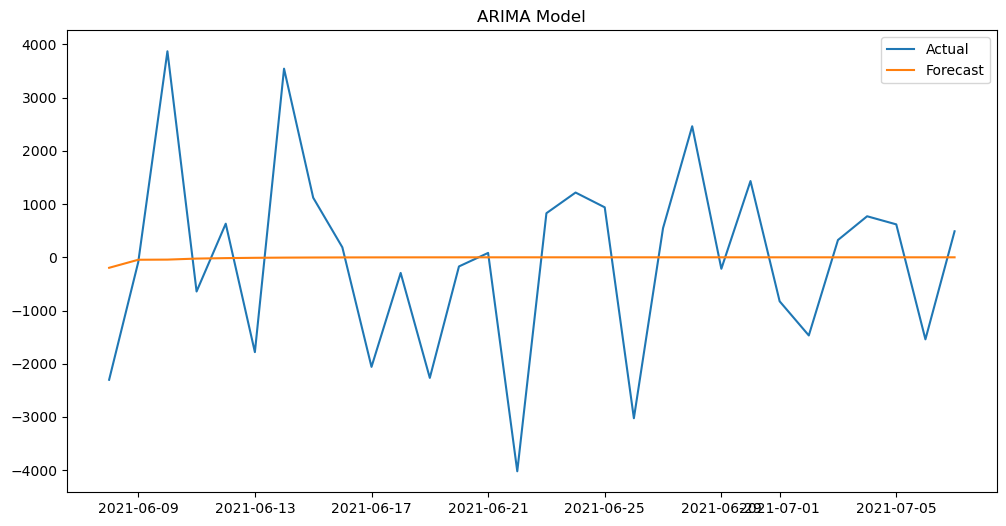

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('ARIMA Model')
plt.plot(test_arima.index, test_arima, label='Actual')
plt.plot(test_arima.index, forecast, label='Forecast')
plt.legend()
plt.show()

In [130]:
lag_count = 30
bitcoin_lagged = bitcoin[['Close']].copy()
for i in range(lag_count,0,-1):
    bitcoin_lagged['t='+str(i)] = bitcoin_lagged['Close'].shift(i)
bitcoin_lagged.dropna(inplace=True)
bitcoin_lagged.head()

,Close,t=30,t=29,t=28,t=27,t=26,t=25,t=24,t=23,t=22,...,t=10,t=9,t=8,t=7,t=6,t=5,t=4,t=3,t=2,t=1
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-29 23:59:59,132.300003,144.539993,139.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,...,121.989998,122.000000,122.879997,123.889000,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000
2013-05-30 23:59:59,128.798996,139.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,...,122.000000,122.879997,123.889000,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000,132.300003
2013-05-31 23:59:59,129.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,...,122.879997,123.889000,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000,132.300003,128.798996
2013-06-01 23:59:59,129.300003,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,...,123.889000,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000,132.300003,128.798996,129.000000
2013-06-02 23:59:59,122.292000,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,...,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000,132.300003,128.798996,129.000000,129.300003


In [131]:
train = bitcoin_lagged.iloc[:-forecast_length]
test = bitcoin_lagged.iloc[-forecast_length:]

In [132]:
from sklearn.model_selection import train_test_split

X = train.drop('Close', axis=1)
y = train['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [133]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [134]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=300, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=300, random_state=42)

In [135]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = gb_model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)*100

3.7556996134228764

In [136]:
import numpy as np


def get_first_eval_batch(data, n):
    return data[-n:].reshape(-1, n)

def make_predictions(train_data, test_data, model, lag_count):
    test_prediction_rfr = []
    current_batch = get_first_eval_batch(train_data, lag_count)

    for i in range(len(test_data)):
        current_batch_df = pd.DataFrame(current_batch, columns=X_train.columns)
        current_pred = model.predict(current_batch_df)[0]
        test_prediction_rfr.append(current_pred)
        current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, lag_count)
    return test_prediction_rfr

In [137]:
test_prediction_rfr = make_predictions(train['Close'].values, test['Close'].values, rf_model, lag_count)
test_prediction_gb = make_predictions(train['Close'].values, test['Close'].values, gb_model, lag_count)

In [138]:
print(f'Rfr MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_rfr)*100}')
print(f'GB MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_gb)*100}')

Rfr MAPE: 5.551131570361935
GB MAPE: 12.95900216794854


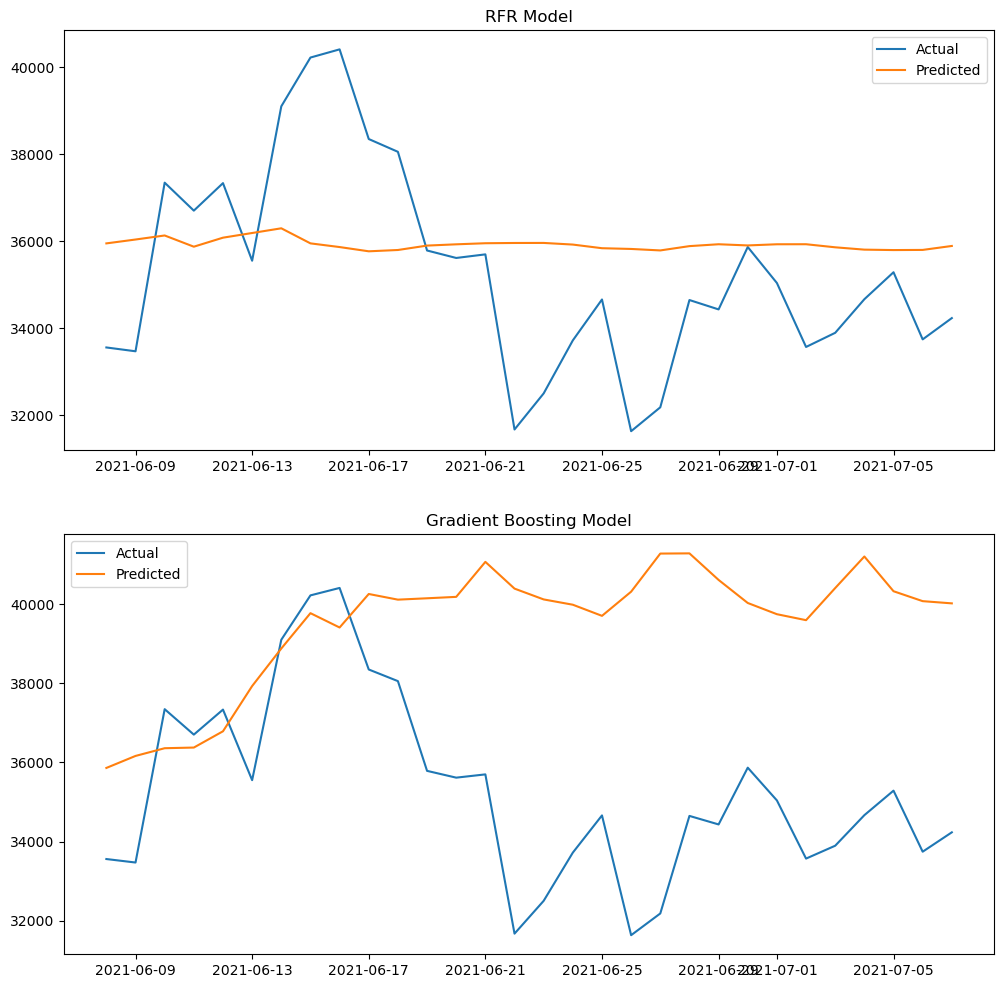

In [139]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, figsize=(12, 12))

axs[0].plot(test.index, test['Close'], label='Actual')
axs[0].plot(test.index, test_prediction_rfr, label='Predicted')
axs[0].set_title('RFR Model')
axs[0].legend()


axs[1].plot(test.index, test['Close'], label='Actual')
axs[1].plot(test.index, test_prediction_gb, label='Predicted')
axs[1].set_title('Gradient Boosting Model')
axs[1].legend()

plt.show()